### Helpers

In [18]:
# %load_ext autoreload
# %autoreload 2

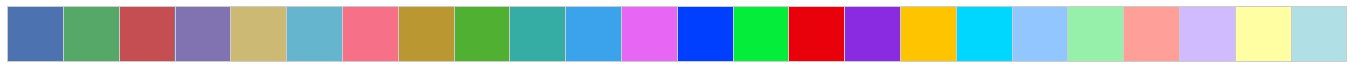

In [9]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err, err_cols

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [2]:
# derivative cols

In [3]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols
train = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 51)

(421218, 578782)

Wall time: 2.18 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [75]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        self.origin_features = [] + xyz_cols + mom_cols + hit_type_cols + exy_cols + edxy_cols + dxyz_cols
        features = self.origin_features.copy()

#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
#         add_dll(data, features)
        
#         filter_data(data)
        
        if not features:
            raise('no features')
    
        self.features = features[len(self.origin_features):]
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.774899,0.767886,0.879719,0.819992,0.797169,0.645465,0.099364,0.0
std,0.003778,0.004678,0.005450,0.002753,0.007492,0.027821,0.005443,0.0
min,0.770708,0.762712,0.873906,0.817400,0.788590,0.627676,0.094049,0.0
25%,0.773327,0.765920,0.877221,0.818548,0.794541,0.629435,0.096583,0.0
50%,0.775945,0.769128,0.880536,0.819696,0.800492,0.631194,0.099117,0.0
75%,0.776995,0.770473,0.882625,0.821289,0.801458,0.654359,0.102022,0.0
max,0.778044,0.771818,0.884714,0.822882,0.802424,0.677525,0.104927,0.0


Wall time: 3.83 s


### Test theory

In [30]:
%%time
df_scores = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.782860,0.775584,0.880142,0.824561,0.804353,0.714752,0.083997,0.0
std,0.001785,0.001175,0.002379,0.001551,0.002663,0.036212,0.001747,0.0
min,0.780439,0.773833,0.877878,0.822579,0.802029,0.672654,0.081327,0.0
25%,0.782250,0.775579,0.878655,0.823905,0.802883,0.697264,0.083390,0.0
50%,0.782411,0.775674,0.878838,0.824048,0.803865,0.705466,0.084420,0.0
75%,0.784239,0.775689,0.882028,0.826001,0.804108,0.730356,0.084943,0.0
max,0.784961,0.777145,0.883312,0.826271,0.808880,0.768021,0.085906,0.0


Wall time: 1min 17s


### Get result

In [72]:
test = read_pub_test(used_cols)

In [76]:
%%time
fit_predict_save(sample(train, 400000), test, "out/08_all_nan_mean_400.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 1min 59s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [80]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols
import warnings

In [8]:
def filter_data(data):
    
    
    return data

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.755993,0.739833,0.875887,0.801960,0.767825,0.959022,0.175372,0.0
std,0.006650,0.013142,0.016250,0.001986,0.007462,0.648297,0.028204,0.0
min,0.750751,0.727273,0.861702,0.800000,0.759483,0.543331,0.146575,0.0
25%,0.752252,0.733006,0.867021,0.800955,0.764806,0.585521,0.161586,0.0
50%,0.753754,0.738739,0.872340,0.801909,0.770129,0.627710,0.176596,0.0
75%,0.758613,0.746114,0.882979,0.802940,0.771996,1.166867,0.189770,0.0
max,0.763473,0.753488,0.893617,0.803970,0.773863,1.706024,0.202944,0.0


In [78]:
dt = sample(train, 1000000).copy()
dt = add_mse(dt, [])
dt = add_coses(dt, [])
dt = add_normed_err(dt, [])

DescribeResult(nobs=267, minmax=(120.04132, 177.67871), mean=134.41702, variance=154.47903, skewness=1.2551014423370361, kurtosis=1.0033730969143893)

DescribeResult(nobs=68, minmax=(120.15215, 172.73096), mean=133.1416, variance=127.68481, skewness=1.2800571918487549, kurtosis=1.4516221522110264)

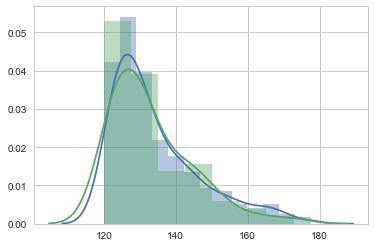

In [121]:
dts = [d[err_cols[0]] for d in split_classes(dt)]
for i in range(2):
    d = dts[i]
    dts[i] = d[(d > 120) & (d < 180)]

dt0 = dts[0].values
dt1 = dts[1].values

display(sts.describe(dt0))
display(sts.describe(dt1))
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    _ = sns.distplot(dt0)
    _ = sns.distplot(dt1)

In [572]:
dl0, dl1 = split_classes(dt)
def plot_stats(x, y, z):
    filtered = x[y > 3]
    print(len(filtered.index), float(len(filtered.index)) / len(x.index), float(len(filtered.index)) / len(z.index))
    
    to_display = filtered.sort_values(by=err_cols[0]).loc[:, err_cols + da_cols + x_cols + ex_cols + mom_cols + hit_stats_cols]
    display(to_display.head(10))

print(len(dt.index))
plot_stats(dl0, dt0, dt)
plot_stats(dl1, dt1, dt)

1000000
219170 0.5203243925948083 0.21917


,ErrMSE,DAngle[1],DAngle[2],DAngle[3],MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],Lextra_X[0],Lextra_X[1],Lextra_X[2],Lextra_X[3],P,PT,FOI_hits_N,NShared,ndof
265766,3.000008,0.999999,0.999648,0.999693,-613.104980,-662.025024,-747.869995,-799.070007,-587.150940,-614.797241,-642.443542,-670.089844,28211.156250,2232.159668,8,1,8
224023,3.000030,0.958856,0.783754,0.976922,-498.355011,-918.700012,-509.869995,-293.369995,-503.163666,-490.089813,-477.015961,-463.942139,9957.242188,1239.924683,10,0,8
122398,3.000110,0.998328,0.999718,0.998902,-187.955002,-196.808334,-199.003326,-245.169998,-191.609543,-218.876740,-246.143951,-273.411163,42377.937500,1027.872437,32,0,8
83415,3.000139,0.993081,0.993812,0.998993,-100.805000,-150.975006,-153.570007,-101.970001,-131.240540,-181.780563,-232.320587,-282.860626,12684.398438,842.619385,31,0,8
344687,3.000162,0.995272,0.958568,0.986733,294.299988,440.660004,259.066681,246.320007,262.729980,253.709793,244.689621,235.669449,17247.693359,1158.968628,17,0,8
409810,3.000228,0.999055,0.999634,0.999926,1901.099976,2106.560059,2276.600098,2433.820068,1825.798584,2008.514893,2191.231201,2373.947510,13235.458984,808.037048,4,0,8
410862,3.000239,0.934341,0.789236,0.896231,-987.580017,-678.075012,-686.869995,-782.070007,-575.068542,-634.472412,-693.876343,-753.280212,36601.164062,1139.545654,5,0,8
401052,3.000273,0.997490,0.994493,0.994572,92.175003,106.001663,21.733334,56.320000,82.284843,76.767242,71.249641,65.732040,44361.558594,1333.897827,7,0,8
202926,3.000289,0.999945,0.999888,0.999985,1086.675049,1185.685059,1265.599976,1353.219971,1123.019897,1230.872437,1338.724976,1446.577515,26373.570312,1144.640259,8,0,8
171205,3.000293,0.999418,0.999503,0.998143,8.758333,50.668335,81.066666,119.653336,-3.462438,27.666750,58.795937,89.925125,16689.105469,1014.551025,4,0,8


42402 0.0732607441143643 0.042402


,ErrMSE,DAngle[1],DAngle[2],DAngle[3],MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],Lextra_X[0],Lextra_X[1],Lextra_X[2],Lextra_X[3],P,PT,FOI_hits_N,NShared,ndof
603611,3.000057,0.999760,0.997328,0.996966,1131.824951,1247.685059,1383.599976,1479.219971,1095.065674,1202.053223,1309.040894,1416.028564,24803.507812,1294.211182,8,0,8
725680,3.000209,0.991817,NaN,NaN,-2532.080078,-2899.300049,NaN,-4113.169922,-2566.201416,-2905.312500,-3244.423584,-3583.534668,4072.801025,866.079468,5,0,6
694901,3.000307,0.999749,0.996582,0.996991,-755.955017,-788.075012,-789.869995,-782.070007,-717.882935,-743.016357,-768.149780,-793.283203,16458.419922,1695.445435,4,0,8
560303,3.000374,0.999321,0.999624,0.999935,410.225006,414.868347,427.566681,426.619995,424.648010,439.905365,455.162750,470.420105,29563.771484,1869.843750,6,0,8
992619,3.000511,0.999749,0.999999,0.999454,534.224976,603.201660,673.400024,751.886658,519.461975,580.332764,641.203552,702.074341,25971.146484,817.379150,12,0,8
585724,3.000564,0.991960,0.995795,0.998973,803.299988,980.960022,1126.599976,1330.319946,759.638855,876.192932,992.747009,1109.301025,9163.140625,968.913208,8,1,8
633624,3.000701,0.999842,0.999798,0.999561,-591.005005,-658.924988,-747.869995,-799.070007,-572.637512,-633.334900,-694.032288,-754.729614,33079.722656,933.088501,5,0,8
926532,3.000739,0.993752,0.999977,0.995012,522.799988,701.260010,886.000000,1199.719971,471.650787,607.442871,743.234924,879.026978,5298.203125,860.183594,22,0,8
988778,3.000943,0.992250,0.974655,0.989569,90.974998,232.860001,139.199997,181.786667,97.440170,100.181976,102.923782,105.665596,106057.507812,2633.217041,12,0,8
733443,3.000992,1.000000,0.999999,0.999997,-347.171661,-375.341675,-405.170013,-433.470001,-333.503693,-348.922699,-364.341736,-379.760773,47523.738281,2400.729492,13,0,8


In [576]:
foi_dt = read_train(foi_xyz_cols + foi_ts_cols, 10000)
foi_dt.head(10)

,FOI_hits_X,FOI_hits_Y,FOI_hits_Z,FOI_hits_T,FOI_hits_DT,FOI_hits_S,label,weight
0,[-101.33 125.651665 20.533333 403.5533...,[325.4549 388.13885 306.61243 135.6677 561.5...,[15119.2705 16412.697 17606.004 19015.29 1...,[ 6 8 1 12 12 1],[ 6 -1 1 12 12 1],[0 1 2 3 3 3],0,17.108124
1,[ 98.59167 98.59167 105.00833 105.00833 1...,[-270.7619 -302.3617 -270.7619 -302.3617 -...,[15320.025 15319.911 15320.025 15319.911 15319...,[ 6 6 6 6 8 8 13 13 2 8 6 2 5 6],[2 0 2 0 2 4 7 9 1 7 5 2 5 6],[0 0 0 0 0 0 0 0 1 1 1 2 2 3],0,3.347705
2,[-1032.205 -1231.7 -1142.325 -1261.87 -1412...,[-159.04198 -172.62701 -172.62701 -184.991 -...,[15117.526 16321.678 16321.678 17514.434 18722...,[ 4 10 5 8 7],[ 3 10 0 -1 0],[0 1 1 2 3],0,28.592901
3,[1578.1 1728.06 1838.6 1963.82],[573.03015 617.38354 661.70636 705.714 ],[15407.064 16614.523 17808.283 19017.342],[4 8 5 4],[ 0 0 -1 -1],[0 1 2 3],0,-54.555294
4,[-1569.63 -1555.63 -1679.45 -1815.97 -1940.67],[ 695.1487 815.0492 878.2637 942.7992 1008....,[15321.604 15205.034 16409.463 17602.494 18810...,[9 9 7 6 6],[ 1 0 -1 -1 -1],[0 0 1 2 3],0,-8.389636
5,[-145.83833 -104.13 -165.125 -201.80333 -...,[-399.3467 -399.3467 -431.58163 -462.5955 -...,[15401.663 15401.663 16605.746 17798.436 19006...,[ 4 2 4 4 1 10],[-1 2 0 4 1 10],[0 0 1 2 3 3],0,6.438138
6,[-2537.68 -2436.63 -2680.9 -2961.57 -3161.77 ...,[1655.0399 1582.543 1782.854 1911.8892 2042....,[15409.061 15324.799 16613.72 17806.986 19015...,[ 8 2 9 4 7 15],[ 0 0 0 -1 0 14],[0 0 1 2 3 3],0,-0.549168
7,[-441.59 -403.09 -326.09 844.42 -...,[-143.21457 -143.21457 -143.21457 158.4553...,[15201.584 15201.584 15201.584 15321.571 16405...,[ 8 9 1 10 8 8 2 12 5 9 1],[ 8 9 1 10 -1 8 2 12 5 0 1],[0 0 0 0 1 2 2 2 2 3 3],0,3.166124
8,[ 327.075 685.05 -91.4 97.3 ...,[ -627.15576 -222.16089 -1061.625 -995.582...,[15117.74 15203.199 16519.477 17802.316 18917...,[12 10 11 1 5 5 6 4 8 15 7],[12 10 11 1 0 -7 0 4 8 1 0],[0 0 1 2 3 3 3 3 3 3 3],0,4.943136
9,[-398.505 -444.50833 -490.67 -461.00333 -...,[ 14.453096 14.517972 -20.694553 -20.694553 -...,[15319.152 16523.354 17599.025 17599.025 18806...,[5 6 5 8 7],[ 0 -1 5 8 7],[0 1 2 2 3],0,18.589046


In [502]:
np.sqrt(1000 / np.pi)

17.841241161527712

In [503]:
np.histogram([0, 1, .5, np.NaN, np.Inf, -.1, 1.1], bins=2, range=(-1, 1.1))

np.digitize([0, 1, .5, np.NaN, np.Inf, -.1, 1.1], [0, 1, np.NaN]) #- 1

array([1, 2, 1, 3, 2, 0, 2], dtype=int64)

In [504]:
np.nanmean([2., 4., 6., np.NaN])

4.0

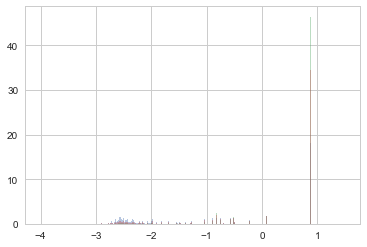

In [567]:
nbins = int(round(np.sqrt(min(len(dt0), len(dt1)) / np.pi)))
# nbins = 100

pdfs = []
binses = []
for i in range(2):
    pdf, bins = np.histogram(dts[i], bins=nbins)
    pdfs.append(np.append(pdf, [np.count_nonzero(np.isnan(dts[i]))]))
    binses.append(np.append(bins, [np.NaN]))

def get_probs(bins, pdf, x):
    indices = np.digitize(x, bins) - 1
    return pdf[indices] / pdf.sum()
    
def plot_dll(x):
    probs = [get_probs(bins, pdf, np.nan_to_num(x)) for bins, pdf in zip(binses, pdfs)]
    DLL = np.log(probs[1]) - np.log(probs[0])
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, hist_kws={ 'range': (-4, 1.5)}, bins=nbins, kde=False, norm_hist=True)
#     _= plt.hist(DLL, range=(-2, 3.5), bins=nbins)

tst = dt[err_cols[0]].values
plot_dll(dt0)
plot_dll(dt1)
plot_dll(tst)

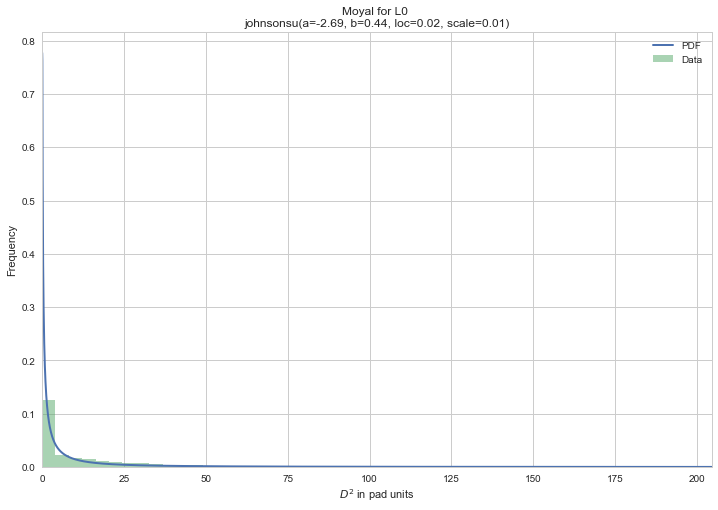

In [506]:
import warnings

def fit_moyal(data, bins):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    params = sts.moyal.fit(x)

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Calculate fitted PDF and error with fit in distribution
    pdf = sts.moyal.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))
    
    return sts.moyal, params

def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        sts.fatiguelife,sts.foldcauchy,sts.loglaplace,sts.johnsonsu,

#         sts.f,sts.lognorm,sts.exponnorm,sts.fisk,sts.t,sts.powerlognorm,
#         sts.alpha,sts.burr,sts.pareto,sts.genextreme,sts.gilbrat,sts.wald,sts.weibull_min,
#         sts.johnsonsb,sts.lomax,sts.mielke,sts.recipinvgauss,
        
#         sts.anglit,sts.arcsine,sts.beta,sts.betaprime,sts.bradford,sts.cauchy,sts.chi,sts.chi2,sts.cosine,
#         sts.dgamma,sts.dweibull,sts.erlang,sts.expon,sts.exponweib,sts.exponpow,
#         sts.foldnorm,sts.frechet_r,sts.frechet_l,sts.genlogistic,sts.genpareto,sts.gennorm,sts.genexpon,
#         sts.gompertz,sts.gumbel_r,sts.gausshyper,sts.gamma,sts.gengamma,sts.genhalflogistic,
#         sts.gumbel_l,sts.halfcauchy,sts.halflogistic,sts.halfnorm,sts.halfgennorm,sts.hypsecant,sts.invgamma,sts.invgauss,
#         sts.invweibull,sts.kstwobign,sts.laplace,sts.levy, sts.levy_l,
#         sts.logistic,sts.loggamma, sts.maxwell, sts.nakagami,
#         sts.norm,sts.pearson3,sts.powerlaw,sts.powernorm,sts.rdist,sts.reciprocal,
#         sts.rayleigh,sts.rice,sts.semicircular,sts.triang,sts.truncexpon,sts.truncnorm,
#         sts.uniform,sts.vonmises,sts.vonmises_line,sts.weibull_max,sts.wrapcauchy, sts.moyal
    ]

    # Best holders
    best_distribution = sts.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # identify if this distribution is better
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse

    return (best_distribution, best_params)
    
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def fit_params(data):
    # Find best fit distribution
    best_dist, best_fit_params = best_fit_distribution(data, 100)
    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True, xlim=(0, data.max()))
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_dist.name, param_str)
    
    # Update plots
    ax.set_title(u'Moyal for L0 \n' + dist_str)
    ax.set_xlabel(u'$D^2$ in pad units')
    ax.set_ylabel('Frequency')    
    
df_dt0 = pd.Series(dt0, name='L0')
fit_params(df_dt0)

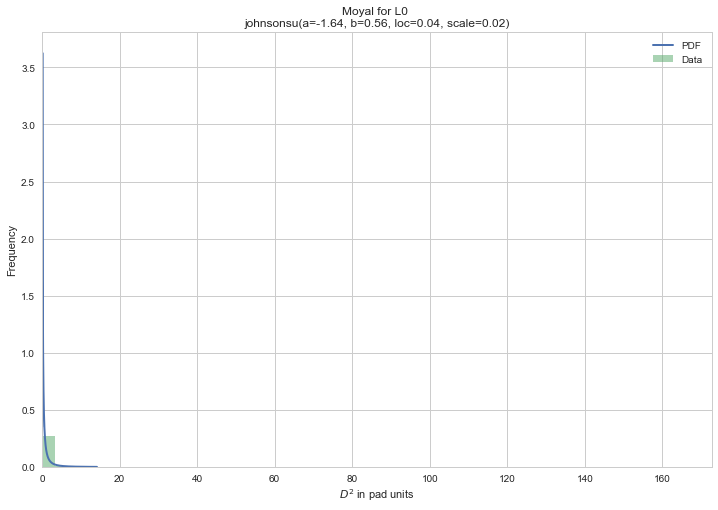

In [507]:
df_dt1 = pd.Series(dt1, name='L1')
fit_params(df_dt1)

In [ ]:
sts.johnsonsu()

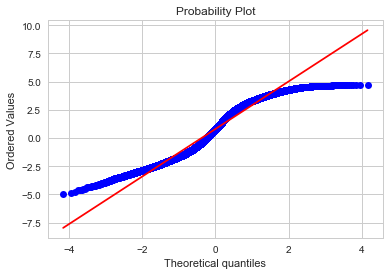

In [142]:
_ = sts.probplot(sts.boxcox(dt0)[0], plot=plt)

In [69]:
dts[1].describe()

count    48855.000000
mean         1.415865
std          6.012142
min          0.004125
25%          0.115471
50%          0.230312
75%          0.562170
max        122.150024
Name: ErrMSE, dtype: float64

C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


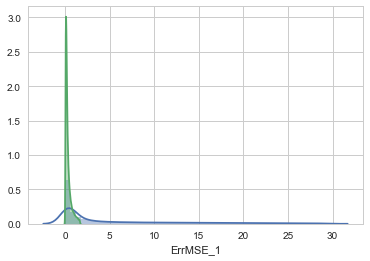

In [89]:
for i in range(2):
    d = dts[i]
    dd = d[d < d.quantile(.9)]
    dd.name += '_{0}'.format(i)
    t = sns.distplot(dd)
#     dd.hist()

t